In [4]:
import matplotlib.pyplot as plt 
import numpy             as np
import torch.nn          as nn
import torch
import json
import os
import sys

from torch_geometric.data   import Batch
from torch_geometric.loader import DataLoader
from libraries.model        import nGCNN, eGCNN, diffusion_step, get_graph_losses, add_features_to_graph, predict_noise, diffuse, denoise, EarlyStopping, get_alpha_t
from libraries.dataset      import standardize_dataset, get_datasets

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

In [6]:
# Based on adding and removing noise to graphs
# The models is able to learn hidden patterns
# It can be conditionally trained with respect to some target property
# Although denoising includes noise, I think it is better not to add it when training

In [7]:
# Define name of data folder where reference dataset are contained
# It shall be consistent with data_folder and data will be moved to models folder
data_name = 'QM9-dsgdb9nsd'  # 'MChX', 'GM_PT_EPA-sphere-images'

# Define folder in which data is stored
data_folder = f'data/{data_name}'

# The folder is named as target_folder_vi (eg, target_folder_v0)
general_folder = f'models/{data_name}'
if not os.path.exists(general_folder):
    # Generate new folder
    os.system(f'mkdir {general_folder}')

# Each new run generates a new folder, with different generations and training most likely (as data might vary as well)
i = 0
while True:
    target_folder = f'{general_folder}/GM_v{i}'
    if not os.path.exists(target_folder):
        # Copy all data
        os.system(f'cp -r {data_folder} {target_folder}')
        break
    i += 1

edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'
target_folder

'models/QM9-dsgdb9nsd/GM_v1'

In [8]:
# Machine-learning parameters
n_epochs      = 100
batch_size    = 64
learning_rate = 0.0001
patience      = n_epochs
delta         = 0.2
check_labels  = False  # Whether to train-test split attending to labels or not

# Number of diffusing and denoising steps
n_t_steps = 500

# Amount of noise for the generative process
sigma = 0  # Zero for training purposes

# Decay of parameter alpha
noise_contribution = 0.1
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.1
dropout_edge = 0.1

# Create and save as a dictionary
model_parameters = {
    'data_folder':        data_folder,
    'n_epochs':           n_epochs,
    'batch_size':         batch_size,
    'learning_rate':      learning_rate,
    'patience':           patience,
    'delta':              delta,
    'check_labels':       check_labels,
    'n_t_steps':          n_t_steps,
    'sigma':              sigma,
    'noise_contribution': noise_contribution,
    'dropout_node':       dropout_node,
    'dropout_edge':       dropout_edge
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_parameters.json', 'w') as json_file:
    json.dump(model_parameters, json_file)

# Load of graph database for training

Load the dataset, already standardized.

In [9]:
labels_name                 = f'{target_folder}/labels.pt'
dataset_name                = f'{target_folder}/dataset.pt'
dataset_name_std            = f'{target_folder}/standardized_dataset.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if os.path.exists(dataset_name_std) and os.path.exists(dataset_parameters_name_std) and os.path.exists(labels_name):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std)
    labels  = torch.load(labels_name)
    
    # Load the data from the JSON file
    with open(dataset_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)

    # Convert NumPy arrays back to PyTorch tensors
    dataset_parameters = {}
    for key, value in numpy_dict.items():
        try:
            dataset_parameters[key] = torch.tensor(value)
        except:
            dataset_parameters[key] = value

elif os.path.exists(dataset_name) and os.path.exists(labels_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, dataset_parameters = standardize_dataset(dataset)
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {key: value.cpu().numpy().tolist() for key, value in dataset_parameters.items()}

    # Dump the dictionary with numpy arrays to a JSON file
    with open(dataset_parameters_name_std, 'w') as json_file:
        json.dump(numpy_dict, json_file)

else:
    sys.exit('Error: the database is not available')

# Defining target factor
target_factor = dataset_parameters['target_std'] / dataset_parameters['scale']

Split in train, validation and test sets.

In [10]:
train_ratio = 0.98
test_ratio  = 0.01

# Check if data has been already split, else do it randomly
path_to_train_labels = f'{target_folder}/train_labels.txt'
path_to_val_labels   = f'{target_folder}/validation_labels.txt'
path_to_test_labels  = f'{target_folder}/test_labels.txt'

# Copy labels
material_labels = labels.copy()

if os.path.exists(path_to_train_labels) and os.path.exists(path_to_val_labels) and os.path.exists(path_to_test_labels):
    # Read labels splitting (which are strings)
    train_labels = np.genfromtxt(path_to_train_labels, dtype='str').tolist()
    val_labels   = np.genfromtxt(path_to_val_labels,   dtype='str').tolist()
    test_labels  = np.genfromtxt(path_to_test_labels,  dtype='str').tolist()
else:
    if check_labels:
        # Splitting into train-test sets considering that Fvs from the same materials must be in the same dataset
        material_labels = [label.split()[0] for label in material_labels]
        
        # Define unique labels
        unique_labels = np.unique(material_labels)
    else:
        # Completely randomly splitting
        # Copy material_labels
        unique_labels = material_labels.copy()
    
    # Shuffle the list of unique labels
    np.random.shuffle(unique_labels)

    # Define the sizes of the train and test sets
    # Corresponds to the size wrt the number of unique materials in the dataset
    train_size = int(train_ratio * len(unique_labels))
    test_size  = int(test_ratio  * len(unique_labels))
    
    train_labels = unique_labels[:train_size]
    val_labels   = unique_labels[train_size:-test_size]
    test_labels  = unique_labels[-test_size:]

    # Save this splitting for transfer-learning approaches
    np.savetxt(path_to_train_labels, train_labels, fmt='%s')
    np.savetxt(path_to_val_labels,   val_labels,   fmt='%s')
    np.savetxt(path_to_test_labels,  test_labels,  fmt='%s')

# Use the computed indexes to generate train and test sets
# We iteratively check where labels equals a unique train/test labels and append the index to a list
train_dataset = get_datasets(train_labels, material_labels, dataset)
val_dataset   = get_datasets(val_labels,   material_labels, dataset)
test_dataset  = get_datasets(test_labels,  material_labels, dataset)

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 131207
Number of validation graphs: 1340
Number of testing    graphs: 1338


In [11]:
for graph in train_dataset:
    graph.y = torch.tensor([0], dtype=torch.float)

for graph in val_dataset:
    graph.y = torch.tensor([0], dtype=torch.float)

for graph in test_dataset:
    graph.y = torch.tensor([0], dtype=torch.float)

Define data loaders.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, pin_memory=True)

# Determine number of node-level features in dataset
n_node_features = train_dataset[0].num_node_features

# Determine the number of graph-level features to be predicted
n_graph_features = len(train_dataset[0].y)

del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Definition of the model

In [13]:
# Instantiate the models for nodes and edges, considering the t_step information; n_graph_features+1 for accounting for the time step
node_model = nGCNN(n_node_features, n_graph_features+1, dropout_node).to(device)
edge_model = eGCNN(n_node_features, n_graph_features+1, dropout_edge).to(device)

# Load previous model if available
try:
    # Load model state
    node_model.load_state_dict(torch.load(node_model_name))
    edge_model.load_state_dict(torch.load(edge_model_name))

    # Evaluate model state
    node_model.eval()
    edge_model.eval()
except FileNotFoundError:
    pass

# Allow data parallilization among multi-GPU
node_model = nn.DataParallel(node_model)
edge_model = nn.DataParallel(edge_model)

# Moving models to device
node_model = node_model.to(device)
edge_model = edge_model.to(device)

print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
nGCNN(
  (conv1): GraphConv(6, 128)
  (conv2): GraphConv(128, 256)
  (conv3): GraphConv(256, 4)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Edge GCNN:
eGCNN(
  (linear1): Linear(in_features=7, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)


# Training of the model

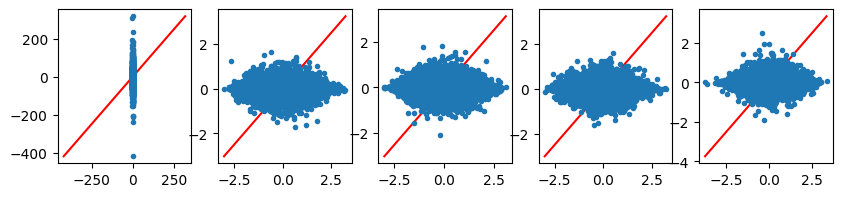

Epoch: 1, edge loss: 22.9141, node loss: 0.4109 0.4115 0.3955 0.4503


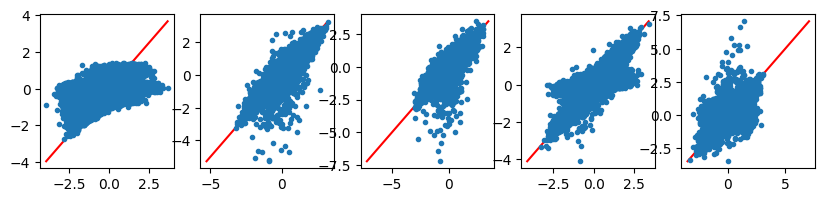

Epoch: 2, edge loss: 0.4632, node loss: 0.0160 0.0205 0.0583 0.0882


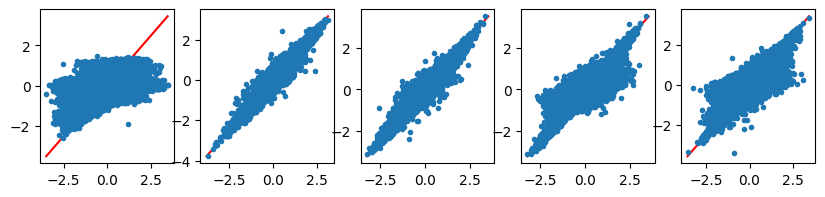

Epoch: 3, edge loss: 0.4631, node loss: 0.0079 0.0092 0.0310 0.0270


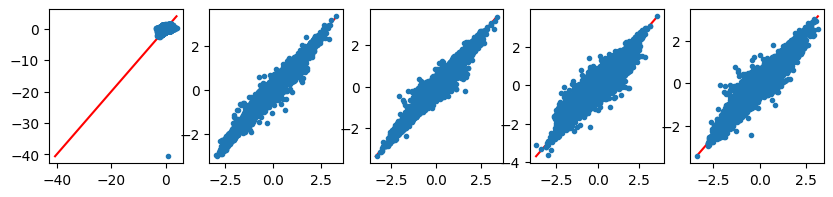

Epoch: 4, edge loss: 0.4629, node loss: 0.0059 0.0060 0.0147 0.0133


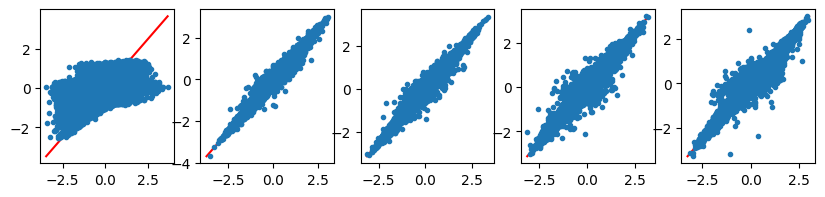

Epoch: 5, edge loss: 0.4627, node loss: 0.0047 0.0049 0.0092 0.0089


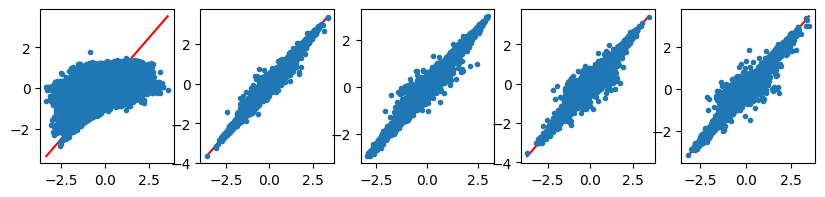

Epoch: 6, edge loss: 0.4627, node loss: 0.0040 0.0043 0.0074 0.0071


KeyboardInterrupt: 

In [14]:
# Data is randomly stored with this ratio
sampling_ratio = 0.1

node_attributes_list = ['edge_attr', 'atomic_mass', 'charge', 'electronegativity', 'ionization_energy']

def append_to_dict(dictionary, key, value):
    dictionary[key].append(value.cpu().detach().numpy().tolist())

# Initialize the optimizers
node_optimizer = torch.optim.Adam(node_model.parameters(), lr=learning_rate)
edge_optimizer = torch.optim.Adam(edge_model.parameters(), lr=learning_rate)

# Initialize early stopping
node_early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=node_model_name)
edge_early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=edge_model_name)

# Training loop
edge_train_losses = []
node_train_losses = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    edge_loss_cum = 0
    node_loss_cum = np.zeros(n_node_features, dtype=float)
    ground_truth = {k: [] for k in node_attributes_list}
    prediction   = {k: [] for k in node_attributes_list}

    for batch_idx, batch_0 in enumerate(train_loader):
        # Clone batch of graphs and move to device
        g_batch_0 = batch_0.clone().to(device)
        
        # Read number of graphs in batch
        batch_size_0 = g_batch_0.num_graphs

        # Save graph-level embeddings
        embedding_batch_0 = [g_batch_0[idx].y for idx in range(batch_size_0)] 
        
        # Start denoising-diffusing process
        for t_step in range(n_t_steps):
            # Initialize the gradient of the optimizers
            node_optimizer.zero_grad()
            edge_optimizer.zero_grad()
            
            # Read time step, which is added to node-level graph embeddings
            # Standard normalization
            t_step_std = torch.tensor([t_step / n_t_steps - 0.5], dtype=torch.float).to(device)
        
            # Diffuse the graph with Gaussian noise
            
            # Perform a diffusion step at time step t_step for each graph within the batch, treated as a whole
            g_batch_t, e_batch_t = diffusion_step(g_batch_0, t_step, n_t_steps, alpha_decay)
            
            # Move data to device
            g_batch_t = g_batch_t.to(device)
            e_batch_t = e_batch_t.to(device)
            
            # Update diffused graph as next one
            g_batch_0 = g_batch_t.clone()
            
            # Add embeddings to noisy graphs (t_step information and graph-level embeddings)
            for idx in range(batch_size_0):
                # Add graph-level embedding to graph_t as node embeddings
                g_batch_t[idx] = add_features_to_graph(g_batch_t[idx],
                                                       embedding_batch_0[idx])  # To match graph.y shape
                
                # Add t_step information to graph_t as node embeddings
                g_batch_t[idx] = add_features_to_graph(g_batch_t[idx],
                                                       t_step_std)  # To match graph.y shape, which is 1D
            
            # Denoise the diffused graph
            
            # Predict batch noise at given time step
            pred_epsilon_t = predict_noise(g_batch_t, node_model, edge_model)

            # Get amount of noise that is added
            alpha_t              = get_alpha_t(t_step, n_t_steps, alpha_decay)
            e_batch_t.x         *= torch.sqrt(1 - alpha_t)
            e_batch_t.edge_attr *= torch.sqrt(1 - alpha_t)

            # Randomly sample batches to store data
            if t_step == n_t_steps-1:
                if batch_idx < np.ceil(sampling_ratio * len(train_loader)):
                    for key, idx in zip(node_attributes_list, [None, 0, 1, 2, 3]):
                        append_to_dict(ground_truth, key,      e_batch_t.edge_attr if idx is None else      e_batch_t.x[:, idx])
                        append_to_dict(prediction,   key, pred_epsilon_t.edge_attr if idx is None else pred_epsilon_t.x[:, idx])

            # Backpropagate and optimize

            # Calculate the losses for node features and edge attributes
            node_losses, edge_loss = get_graph_losses(e_batch_t, pred_epsilon_t)
            
            # Combine losses for each attribute tensors
            node_loss = torch.stack(node_losses).sum()
            
            # Get items
            node_loss_cum += np.array([node_loss.item() for node_loss in node_losses])
            edge_loss_cum += edge_loss.item()
            
            # Backpropagate and optimize node loss
            if not node_early_stopping.early_stop:
                node_loss.backward(retain_graph=True)
                torch.nn.utils.clip_grad_norm_(node_model.parameters(), max_norm=2.0)
                node_optimizer.step()

            # Backpropagate and optimize edge loss
            if not edge_early_stopping.early_stop:
                edge_loss.backward(retain_graph=True)
                torch.nn.utils.clip_grad_norm_(edge_model.parameters(), max_norm=2.0)
                edge_optimizer.step()
    
    if True:
        fig, ax = plt.subplots(1, 5, figsize=(10, 2))
        for idx, item in enumerate(ground_truth):
            ground_truth_item = np.concatenate(ground_truth[item])
            prediction_item   = np.concatenate(prediction[item])

            _min_ = np.min([np.min(ground_truth_item), np.min(prediction_item)])
            _max_ = np.max([np.max(ground_truth_item), np.max(prediction_item)])

            ax[idx].plot([_min_, _max_], [_min_, _max_], '-r')
            ax[idx].plot(ground_truth_item, prediction_item, '.')
        plt.show()

        # Compute the average train loss over n_t_steps
        node_loss_cum /= (n_t_steps * len(train_loader))
        edge_loss_cum /= (n_t_steps * len(train_loader))

        # Append average losses
        node_train_losses.append(node_loss_cum)
        edge_train_losses.append(edge_loss_cum)

        # Check early stopping criteria
        node_early_stopping(node_loss_cum.sum(), node_model)
        edge_early_stopping(edge_loss_cum,       edge_model)

        if node_early_stopping.early_stop and edge_early_stopping.early_stop:
            print('Early stopping')
            break

        print_node_loss = ' '.join([f'{node_loss:.4f}' for node_loss in node_loss_cum])
        print(f'Epoch: {epoch+1}, edge loss: {edge_loss_cum:.4f}, node loss: {print_node_loss}')

In [12]:
rescaled_edge_train_losses = np.sqrt(edge_train_losses) * dataset_parameters['edge_std'].numpy() + dataset_parameters['edge_mean'].numpy()
rescaled_edge_train_losses

array([0.07803406, 0.07498746, 0.07453655, 0.07431571, 0.07425569,
       0.07422394, 0.07417515, 0.07417601, 0.07415703, 0.07414186,
       0.07413769, 0.07411657, 0.07411257, 0.07411627, 0.07410295,
       0.07410252, 0.07408988, 0.07406298, 0.07407996, 0.07407532,
       0.07408844, 0.07404857, 0.07405724, 0.07407504, 0.07407573,
       0.07405651, 0.07404389, 0.07405169, 0.07405628, 0.07405309,
       0.07404258, 0.07405389, 0.07403108, 0.07403017, 0.07403882,
       0.07405602, 0.07404295, 0.07404646, 0.07403582, 0.07403156,
       0.07402808, 0.07403503, 0.07403221, 0.07402347, 0.074041  ,
       0.07404505, 0.07401697, 0.07402317, 0.07403495, 0.07402529,
       0.07404631, 0.07401233, 0.074033  , 0.07404531, 0.07401473,
       0.0740144 , 0.07400944, 0.07402887, 0.07404771, 0.0740072 ,
       0.07403006, 0.07402402, 0.07399848, 0.07400721, 0.07402771,
       0.07403507, 0.07401012, 0.07402026, 0.07401672, 0.0740062 ,
       0.07400127, 0.07400906, 0.07399019, 0.07402491, 0.07403

In [13]:
node_train_losses = np.array(node_train_losses)
rescaled_node_loss_cum = np.sqrt(node_train_losses) * dataset_parameters['feat_std'].numpy() + dataset_parameters['feat_mean'].numpy()
rescaled_node_loss_cum

array([[135.48812557,  55.61292725,   2.52991421,   9.80473162],
       [132.53531153,  54.50620848,   2.51150644,   9.72000039],
       [131.86191832,  54.23622271,   2.50643534,   9.69636476],
       [131.31099862,  54.03362457,   2.50288346,   9.67836735],
       [131.07258632,  53.94371415,   2.50160025,   9.6720657 ],
       [130.94220366,  53.89518102,   2.5004294 ,   9.66723192],
       [130.85656218,  53.85744573,   2.49974949,   9.66469053],
       [130.68580228,  53.79548904,   2.49948513,   9.66424105],
       [130.68045232,  53.79225404,   2.49890735,   9.66155092],
       [130.57878402,  53.75792113,   2.49847761,   9.65952701],
       [130.43718942,  53.69978675,   2.49803833,   9.65679023],
       [130.42145188,  53.69497876,   2.49783733,   9.65703261],
       [130.32170467,  53.65758277,   2.4977002 ,   9.65647518],
       [130.28559459,  53.6381804 ,   2.49732496,   9.65428993],
       [130.25604295,  53.62937581,   2.49692431,   9.65269938],
       [130.16303916,  53

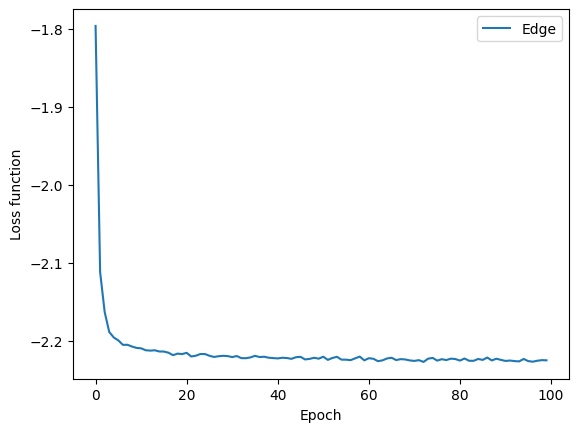

In [14]:
plt.plot(np.log(edge_train_losses), label='Edge')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


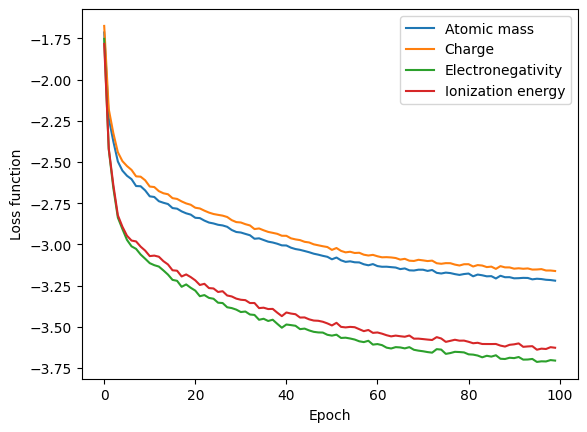

In [15]:
plt.plot(np.log(np.array(node_train_losses)[:, 0]), label=f'Atomic mass')
plt.plot(np.log(np.array(node_train_losses)[:, 1]), label=f'Charge')
plt.plot(np.log(np.array(node_train_losses)[:, 2]), label=f'Electronegativity')
plt.plot(np.log(np.array(node_train_losses)[:, 3]), label=f'Ionization energy')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.savefig('Losses.eps', dpi=50, bbox_inches='tight')
plt.show()

# Test of the model

In [16]:
# Training loop
edge_test_losses = 0
node_test_losses = np.zeros(n_node_features, dtype=float)
idx = 0
for batch_0 in test_loader:
    # Move batch data to GPU
    batch_0 = batch_0.to(device)
    
    # Read number of graphs in batch
    batch_size = batch_0.num_graphs
    
    # Diffuse batch
    g_batch_t = diffuse(batch_0, n_t_steps, s=alpha_decay)
    
    # Denoise batch
    g_batch_0 = denoise(g_batch_t, n_t_steps, node_model, edge_model, n_graph_features,
                        s=alpha_decay, sigma=sigma)
    
    # Calculate the loss for node features and edge attributes
    node_losses, edge_loss = get_graph_losses(batch_0, g_batch_0)
    
    # Get items
    edge_loss_cum = edge_loss.item()
    node_loss_cum = np.array([node_loss.item() for node_loss in node_losses])
    
    # Append average losses
    edge_test_losses += edge_loss_cum
    node_test_losses += node_loss_cum
    
    print_node_loss = ' '.join([f'{node_loss:.4f}' for node_loss in node_loss_cum])
    print(f'Batch: {idx}, edge loss: {edge_loss_cum:.4f}, node loss: {print_node_loss}')
    idx += 1

Batch: 0, edge loss: 0.6256, node loss: 5.0201 4.7923 4.5431 3.7616


In [17]:
node_test_losses /= len(test_loader)
edge_test_losses /= len(test_loader)

In [18]:
edge_test_losses, node_test_losses

(0.6255591511726379, array([5.02006865, 4.79230642, 4.54306364, 3.76162505]))

# Save results

In [19]:
# Create and save as a dictionary
model_performance = {
    'edge_train_losses': edge_train_losses,
    'node_train_losses': np.array(node_train_losses).tolist(),
    'edge_test_losses':  edge_test_losses,
    'node_test_losses':  node_test_losses.tolist()
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_performance.json', 'w') as json_file:
    json.dump(model_performance, json_file)